In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, confusion_matrix,
    roc_auc_score, precision_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
# Convert Total Charges to Numeric and fill missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Convert SeniorCitizen to Object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [4]:
# MuliipleLines column has 'No phone service' value which is same as 'No' value
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

# Replace 'No internet service' with 'No' in the following columns
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in columns_to_replace:
    df[i] = df[i].replace('No internet service', 'No')

In [5]:
# Convert Churn categorical column to numeric
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [7]:
# Create StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)

for train_index, test_index in strat_split.split(df, df['Churn']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

# Check if the split is stratified
print('Train Set Churn Distribution')
print(train_set['Churn'].value_counts(normalize=True))
print('Test Set Churn Distribution')
print(test_set['Churn'].value_counts(normalize=True))

Train Set Churn Distribution
0    0.734647
1    0.265353
Name: Churn, dtype: float64
Test Set Churn Distribution
0    0.734564
1    0.265436
Name: Churn, dtype: float64


In [8]:
X_train = train_set.drop('Churn', axis=1)
y_train = train_set['Churn']

X_test = test_set.drop('Churn', axis=1)
y_test = test_set['Churn']

In [9]:
X_train

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3174,6968-MHOMU,Male,0,Yes,No,58,No,No,DSL,No,No,No,No,Yes,Yes,One year,Yes,Credit card (automatic),45.00,2689.35
3896,8590-OHDIW,Female,0,Yes,Yes,38,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,20.30,749.35
1445,3211-AAPKX,Male,0,No,No,20,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,98.55,2031.95
5670,7812-FZHPE,Female,0,Yes,Yes,17,Yes,Yes,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,24.10,409.90
4285,1506-YJTYT,Male,0,Yes,Yes,45,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic),73.85,3371.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5506,8048-DSDFQ,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.20,20.20
5725,9648-BCHKM,Female,0,Yes,Yes,18,Yes,Yes,No,No,No,No,No,No,No,Two year,Yes,Credit card (automatic),24.65,471.35
1268,2408-TZMJL,Male,0,Yes,No,59,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,110.15,6448.05
3912,3882-IYOIJ,Female,0,Yes,Yes,60,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),115.25,6758.45


In [10]:
# Save the split data
import joblib

joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [11]:
# Identify categorical columns
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

In [12]:
# Initialize and fit CatBoost model
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=False, scale_pos_weight=3)
cat_model.fit(X_train, y_train, cat_features=cat_columns, eval_set=(X_test, y_test))

# Predict on test set
y_pred = cat_model.predict(X_test)

In [13]:
# Evaluate model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('AUC Score:', roc_auc_score(y_test, y_pred))

Accuracy: 0.7743080198722498
Precision: 0.5492957746478874
Recall: 0.8342245989304813
F1 Score: 0.6624203821656052
AUC Score: 0.7934408018806995


In [14]:
# Create a dataframe to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'])
results = results.append({
    'Model': 'CatBoost',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'AUC Score': roc_auc_score(y_test, y_pred)
}, ignore_index=True)

In [15]:
# Display results
results

,Model,Accuracy,Precision,Recall,F1 Score,AUC Score
0,CatBoost,0.774308,0.549296,0.834225,0.66242,0.793441


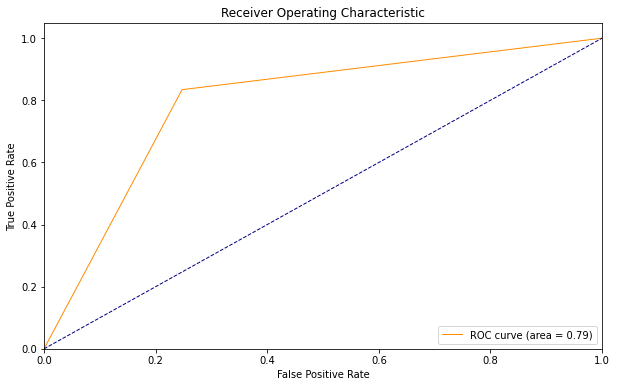

In [16]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

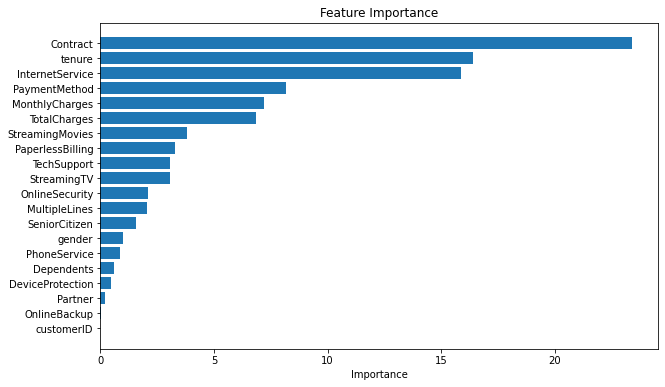

In [17]:
# Plot Feature Importance
feature_importance = cat_model.get_feature_importance()
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

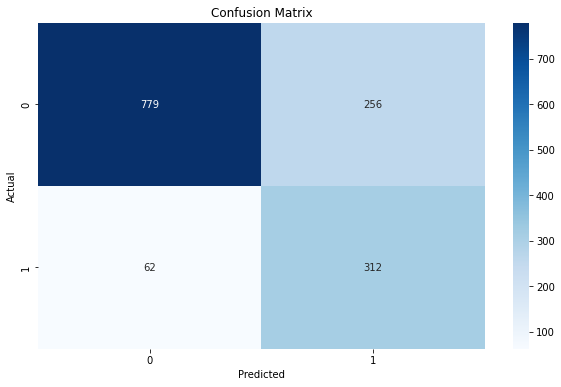

In [18]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Display Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1035
           1       0.55      0.83      0.66       374

    accuracy                           0.77      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.83      0.77      0.79      1409



In [20]:
# Save model
cat_model.save_model('catboost_model')